# IMPORTS REQUIRED PACKAGES

#### Run the cell below only if seaborn has not been installed in your virtual environment yet

In [1]:
#! pip install seaborn


#### Import all required packages and sub models

In [ ]:
%%capture
import warnings; warnings.filterwarnings("ignore")

import glob
import seaborn as sns
import pandas as pd
import os
import sys
import time
import traceback
import matplotlib.pyplot as plt, numpy as np
%matplotlib inline

import orca
from baus import datasources
from baus import variables
from baus import models
from baus import slr
from baus import earthquake
from baus import ual
from baus import validation
import socket
from baus.utils import compare_summary

#### Define relevant functions (from baus.py)

In [3]:

def get_simulation_models(SCENARIO):

    # ual has a slightly different set of models - might be able to get rid
    # of the old version soon

    models = [

        "slr_inundate",
        "slr_remove_dev",
        "eq_code_buildings",
        "earthquake_demolish",

        "neighborhood_vars",    # street network accessibility
        "regional_vars",        # road network accessibility

        "nrh_simulate",         # non-residential rent hedonic

        # uses conditional probabilities
        "households_relocation",
        "households_transition",
        # update building/unit/hh correspondence
        "reconcile_unplaced_households",

        "jobs_relocation",
        "jobs_transition",

        "balance_rental_and_ownership_hedonics",

        "price_vars",
        "scheduled_development_events",

        # run the subsidized acct system
        "lump_sum_accounts",
        "subsidized_residential_developer_lump_sum_accts",

        "alt_feasibility",

        "residential_developer",
        "developer_reprocess",
        "retail_developer",
        "office_developer",
        "accessory_units",

        # (for buildings that were removed)
        "remove_old_units",
        # set up units for new residential buildings
        "initialize_new_units",
        # update building/unit/hh correspondence
        "reconcile_unplaced_households",

        "rsh_simulate",     # residential sales hedonic for units
        "rrh_simulate",     # residential rental hedonic for units

        # (based on higher of predicted price or rent)
        "assign_tenure_to_new_units",

        # allocate owners to vacant owner-occupied units
        "hlcm_owner_simulate",
        # allocate renters to vacant rental units
        "hlcm_renter_simulate",

        # we have to run the hlcm above before this one - we first want to
        # try and put unplaced households into their appropraite tenured
        # units and then when that fails, force them to place using the
        # code below.  technically the hlcms above could be moved above the
        # developer again, but we would have to run the hedonics twice and
        # also the assign_tenure_to_new_units twice.

        # force placement of any unplaced households, in terms of rent/own
        # is a noop except in the final simulation year
        "hlcm_owner_simulate_no_unplaced",
        # this one crashes right no because there are no unplaced, so
        # need to fix the crash in urbansim
        "hlcm_renter_simulate_no_unplaced",

        # update building/unit/hh correspondence
        "reconcile_placed_households",

        "proportional_elcm",        # start with a proportional jobs model
        "elcm_simulate",            # displaced by new dev

        # save_intermediate_tables", # saves output for visualization

        "topsheet",
        "simulation_validation",
        "parcel_summary",
        "building_summary",
        "diagnostic_output",
        "geographic_summary",
        "travel_model_output",
        # "travel_model_2_output",
        "hazards_slr_summary",
        "hazards_eq_summary",
        "save_tenure_indicators"

    ]

    # calculate VMT taxes
    vmt_settings = \
        orca.get_injectable("settings")["acct_settings"]["vmt_settings"]
    if SCENARIO in vmt_settings["com_for_com_scenarios"]:
        models.insert(models.index("office_developer"),
                      "subsidized_office_developer")

    if SCENARIO in vmt_settings["com_for_res_scenarios"] or \
            SCENARIO in vmt_settings["res_for_res_scenarios"]:

        models.insert(models.index("diagnostic_output"),
                      "calculate_vmt_fees")
        models.insert(models.index("alt_feasibility"),
                      "subsidized_residential_feasibility")
        models.insert(models.index("alt_feasibility"),
                      "subsidized_residential_developer_vmt")

    return models


def run_models(MODE, SCENARIO):

    if MODE == "simulation":
        print ("running")

        # see above for docs on this
        if not SKIP_BASE_YEAR:
            orca.run([

                "slr_inundate",
                "slr_remove_dev",
                "eq_code_buildings",
                "earthquake_demolish",

                "neighborhood_vars",   # local accessibility vars
                "regional_vars",       # regional accessibility vars

                "rsh_simulate",    # residential sales hedonic for units
                "rrh_simulate",    # residential rental hedonic for units
                "nrh_simulate",


                # uses conditional probabilities
                "households_relocation",
                "households_transition",
                # update building/unit/hh correspondence
                "reconcile_unplaced_households",
                "jobs_transition",

                # (based on higher of predicted price or rent)
                "assign_tenure_to_new_units",

                # allocate owners to vacant owner-occupied units
                "hlcm_owner_simulate",
                # allocate renters to vacant rental units
                "hlcm_renter_simulate",
                # update building/unit/hh correspondence
                "reconcile_placed_households",

                "elcm_simulate",

                "price_vars",

                "topsheet",
                "simulation_validation",
                "parcel_summary",
                "building_summary",
                "geographic_summary",
                "travel_model_output",
                # "travel_model_2_output",
                "hazards_slr_summary",
                "hazards_eq_summary",
                "diagnostic_output",
                "config",
                "save_tenure_indicators"

            ], iter_vars=[IN_YEAR])

        # start the simulation in the next round - only the models above run
        # for the IN_YEAR
        years_to_run = range(IN_YEAR+EVERY_NTH_YEAR, OUT_YEAR+1,
                             EVERY_NTH_YEAR)
        models = get_simulation_models(SCENARIO)
        orca.run(models, iter_vars=years_to_run)




# EXECUTES SIMULATIONS

* This section of the notebook runs two different scenarios for testing purposes: 4 and 5. Scenario 4 is the base scenario, while scenario 5 has been added as requested by MTC. It has larger values for control totals and therefore was the most problematic in terms of tenure imbalances. 


* The cells below execute the same sequence of steps that is coded in baus.py. The steps are called directly from this notebook instead of running python baus.py -c -s to enable retrieving injectables that are created during the simulation. 


* The new "units_tenure_track" and "households_tenure_track" injectables allow extracting information about tenure split for all simulation years. These injectables will be retrieved and stored to create plots of the evolution of tenure at the end of this notebook.



#### SCENARIO 4

In [4]:
SCENARIO = 4
IN_YEAR, OUT_YEAR = 2010, 2015

pd.set_option('display.float_format', lambda x: '%.3f' % x)
LOGS = True
INTERACT = False
MODE = "simulation"
S3 = False
EVERY_NTH_YEAR = 5
SKIP_BASE_YEAR = False
COMPARE_AGAINST_LAST_KNOWN_GOOD = False
orca.add_injectable("years_per_iter", EVERY_NTH_YEAR)
run_num = orca.get_injectable("run_number")


In [7]:
run_models(MODE, SCENARIO)


running
Running iteration 1 with iteration value 2010
Running step 'slr_inundate'
Time to execute step 'slr_inundate': 2.77 s
Running step 'slr_remove_dev'
Time to execute step 'slr_remove_dev': 1.63 s
Running step 'eq_code_buildings'
Time to execute step 'eq_code_buildings': 0.00 s
Running step 'earthquake_demolish'
Time to execute step 'earthquake_demolish': 1.23 s
Running step 'neighborhood_vars'
Computing accessibility variables
Computing retail_sqft_3000
Computing sum_income_3000
Computing residential_units_500
Computing residential_units_1500
Computing office_1500
Computing retail_1500
Computing industrial_1500
Computing ave_sqft_per_unit
Computing ave_lot_size_per_unit
Computing population
Computing poor
Computing renters
Computing sfdu
Computing ave_hhsize
Computing jobs_500
Computing jobs_1500
Computing ave_income_1500
Computing ave_income_500
       retail_sqft_3000  sum_income_3000  residential_units_500  \
count        226060.000       226060.000             226060.000   
m

/Users/Jessica/anaconda/envs/mtc-env2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


count   2215961.000
mean        505.477
std         223.147
min       -4500.805
25%         349.424
50%         476.485
75%         620.120
max        1305.208
dtype: float64
Clipping produces
count   2800260.000
mean        444.576
std         229.340
min         200.000
25%         209.009
50%         411.588
75%         572.291
max        1305.208
Name: unit_residential_price, dtype: float64
Time to execute step 'rsh_simulate': 68.86 s
Running step 'rrh_simulate'
count   2800260.000
mean          2.225
std           0.779
min          -3.488
25%           1.769
50%           2.276
75%           2.719
max           4.543
dtype: float64
Clipping produces
count   2800260.000
mean          2.248
std           0.720
min           0.833
25%           1.769
50%           2.276
75%           2.719
max           4.543
Name: unit_residential_rent, dtype: float64
Time to execute step 'rrh_simulate': 13.18 s
Running step 'nrh_simulate'
count   88236.000
mean       20.757
std         9.568
min  

row closeness 52744.37806364664
col closeness 12512.990453790699
row closeness 2688.159285392637
col closeness 689.340234573232
row closeness 139.7747332891194
col closeness 36.207159132522065
row closeness 7.240033757876834
col closeness 1.8795105504104868
row closeness 0.3744550977072931
row closeness 623.4827250956569
col closeness 28.74496199830901
row closeness 5.400326957907486
col closeness 1.7983459297101945
row closeness 0.5202826610511742
row closeness 776.897912519836
col closeness 88.59104302251944
row closeness 18.461396838507245
col closeness 4.325521893508267
row closeness 1.187592623571034
col closeness 1.0000000001455192
row closeness 1.0000000001565974
col closeness 1.0000000000582077
row closeness 1.0000000001000018
col closeness 0.9999999999417923
row closeness 30.88284166948852
col closeness 9.66450261126738
row closeness 2.0837682295758593
col closeness 0.6489210319705307
Time to execute step 'travel_model_output': 166.33 s
Running step 'hazards_slr_summary'
Time 

Total agents after transition: 4010135
Time to execute step 'jobs_transition': 5.16 s
Running step 'balance_rental_and_ownership_hedonics'
Owner utilization = 0.991
Renter utilization = 0.979
Ratio of renter utilization to owner utilization = 0.988
Modified ratio = 0.706
New cap rate = 0.01
Time to execute step 'balance_rental_and_ownership_hedonics': 0.67 s
Running step 'price_vars'
Computing accessibility variables
Computing residential
Removed 147270 rows because they contain missing values
Computing retail
Computing office
Computing industrial
       residential     retail     office  industrial
count   226060.000 226060.000 226060.000  226060.000
mean      2549.077     18.386     23.939       8.656
std        765.699      9.771     11.668       7.099
min         -1.000     -1.000     -1.000      -1.000
25%       2099.059     17.314     17.630      -1.000
50%       2681.137     20.728     22.218      10.010
75%       3059.452     23.052     29.972      12.697
max       5012.742    

Modifying profit for SB743:
count   169152.000
mean         1.011
std          0.011
min          0.980
25%          1.000
50%          1.020
75%          1.020
max          1.020
Name: (residential, vmt_res_cat), dtype: float64
Modifying profit for CEQA:
count   1956212.000
mean          1.005
std           0.005
min           1.000
25%           1.000
50%           1.000
75%           1.010
max           1.010
dtype: float64
Modifying profit for Reduce Parking Requirements in PDAs:
count   1956212.000
mean          1.001
std           0.003
min           1.000
25%           1.000
50%           1.000
75%           1.000
max           1.010
dtype: float64
There are 247957 affordable units if all feasible projects are built
Time to execute step 'alt_feasibility': 173.80 s
Running step 'residential_developer'
Using default limits
Number of agents: 2,760,479
Number of agent spaces: 2,817,372
Current vacancy = 0.02
Target vacancy = 0.01, target of new units = 0
Running developer for Clover

/Users/Jessica/anaconda/envs/mtc-env2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


count   2237296.000
mean        502.987
std         235.356
min       -4500.805
25%         345.943
50%         475.040
75%         622.578
max        1305.208
dtype: float64
Clipping produces
count   2824909.000
mean        443.764
std         229.894
min         200.000
25%         204.716
50%         409.580
75%         573.020
max        1305.208
Name: unit_residential_price, dtype: float64
Time to execute step 'rsh_simulate': 30.52 s
Running step 'rrh_simulate'
count   2824909.000
mean          2.225
std           0.780
min          -3.492
25%           1.769
50%           2.279
75%           2.721
max           4.541
dtype: float64
Clipping produces
count   2824909.000
mean          2.249
std           0.721
min           0.833
25%           1.769
50%           2.279
75%           2.721
max           4.541
Name: unit_residential_rent, dtype: float64
Time to execute step 'rrh_simulate': 12.07 s
Running step 'assign_tenure_to_new_units'
Adding tenure assignment to 27269 new residen

baus/models.py:250: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buildings.general_type.isin(["Office", "School"])]


Need more jobs total: 792
Available jobs: 181609
Need more jobs
152      1.000
158      5.000
192      2.000
194     11.000
216      6.000
232      1.000
243     28.000
245     21.000
352      9.000
413      3.000
436     54.000
489      4.000
572      2.000
587      3.000
614     28.000
616     87.000
631     38.000
646      2.000
667      2.000
727     56.000
790      1.000
807      8.000
808      8.000
813      1.000
849      5.000
865     10.000
877     17.000
888     15.000
916      8.000
1052     3.000
1064     3.000
1076    27.000
1114     9.000
1173    10.000
1207    12.000
1210    11.000
1269    25.000
1274    35.000
1275     8.000
1285   166.000
1309    47.000
dtype: float64
Excess demand
1309   14.000
dtype: float64
We don't have any locations for these locations:
Int64Index([], dtype='int64')
Time to execute step 'proportional_elcm': 17.60 s
Running step 'elcm_simulate'
There are 5367122 total available units
    and 4010135 total choosers
    but there are 16699 overfull b

In [9]:
units_s4 = orca.get_injectable('units_tenure_track')
households_s4 = orca.get_injectable('households_tenure_track')

#### SCENARIO 5

In [10]:
SCENARIO = 5
IN_YEAR, OUT_YEAR = 2010, 2015


In [11]:
run_models(MODE, SCENARIO)


running
Running iteration 1 with iteration value 2010
Running step 'slr_inundate'
Time to execute step 'slr_inundate': 0.00 s
Running step 'slr_remove_dev'
Time to execute step 'slr_remove_dev': 0.00 s
Running step 'eq_code_buildings'
Time to execute step 'eq_code_buildings': 0.00 s
Running step 'earthquake_demolish'
Time to execute step 'earthquake_demolish': 0.00 s
Running step 'neighborhood_vars'
Computing accessibility variables
Computing retail_sqft_3000
Computing sum_income_3000
Removed 186455 rows because they contain missing values
Computing residential_units_500
Computing residential_units_1500
Computing office_1500
Computing retail_1500
Computing industrial_1500
Computing ave_sqft_per_unit
Computing ave_lot_size_per_unit
Computing population
Removed 186455 rows because they contain missing values
Computing poor
Removed 61734 rows because they contain missing values
Computing renters
Computing sfdu
Computing ave_hhsize
Removed 186455 rows because they contain missing values
Co

There are 1626132 total available units
    and 1510809 total choosers
    but there are 0 overfull buildings
    for a total of 132075 temporarily empty units
    in 132075 buildings total in the region
There are 16752 total movers for this LCM
Number of submarkets where demand exceeds supply: 0
Running supply and demand
Simulated Prices
count   1626132.000
mean        413.157
std         203.000
min         200.000
25%         200.000
50%         386.816
75%         539.734
max        1285.365
Name: unit_residential_price, dtype: float64
Submarket Price Shifters
count   1454.000
mean       1.000
std        0.000
min        1.000
25%        1.000
50%        1.000
75%        1.000
max        1.000
dtype: float64
Adjusted Prices
count   1626132.000
mean        413.157
std         203.000
min         200.000
25%         200.000
50%         386.816
75%         539.734
max        1285.365
Name: unit_residential_price, dtype: float64
Assigned 16752 choosers to new units
Total currently unpl

Time to execute step 'save_tenure_indicators': 2.35 s
Total time to execute iteration 1 with iteration value 2010: 1093.99 s
Running iteration 1 with iteration value 2015
Running step 'slr_inundate'
Time to execute step 'slr_inundate': 0.00 s
Running step 'slr_remove_dev'
Time to execute step 'slr_remove_dev': 0.00 s
Running step 'eq_code_buildings'
Time to execute step 'eq_code_buildings': 0.00 s
Running step 'earthquake_demolish'
Time to execute step 'earthquake_demolish': 0.00 s
Running step 'neighborhood_vars'
Computing accessibility variables
Computing retail_sqft_3000
Computing sum_income_3000
Removed 32588 rows because they contain missing values
Computing residential_units_500
Computing residential_units_1500
Computing office_1500
Computing retail_1500
Computing industrial_1500
Computing ave_sqft_per_unit
Computing ave_lot_size_per_unit
Computing population
Removed 32588 rows because they contain missing values
Computing poor
Removed 10295 rows because they contain missing valu

Res units before: 2,824,381.0
Non-res sqft before: 2,246,377,411.79
Res units after: 2,824,909.0
Non-res sqft after: 2,247,916,565.79
Time to execute step 'scheduled_development_events': 7.60 s
Running step 'lump_sum_accounts'
Time to execute step 'lump_sum_accounts': 0.01 s
Running step 'subsidized_residential_developer_lump_sum_accts'
Running the subsidized developer for acct: OBAG
Describe of the yearly rent by use
          retail  industrial     office  residential
count 494017.000  494017.000 494017.000   494017.000
mean      20.362       9.941     24.571       17.496
std       11.932       7.300     11.408        2.013
min       -1.000      -1.000     -1.000        2.172
25%       17.610       7.129     17.852       18.098
50%       21.438      10.564     23.094       18.098
75%       24.524      13.306     31.402       18.098
max       60.546      34.610     67.870       18.098
Computing feasibility for form residential
Making policy modifications to profitability
Sum of reside

Modifying profit for SB743:
count   168600.000
mean         1.011
std          0.011
min          0.980
25%          1.000
50%          1.020
75%          1.020
max          1.020
Name: (residential, vmt_res_cat), dtype: float64
Modifying profit for CEQA:
count   1956212.000
mean          1.005
std           0.005
min           1.000
25%           1.000
50%           1.000
75%           1.010
max           1.010
dtype: float64
Modifying profit for Reduce Parking Requirements in PDAs:
count   1956212.000
mean          1.001
std           0.003
min           1.000
25%           1.000
50%           1.000
75%           1.000
max           1.010
dtype: float64
There are 246619 affordable units if all feasible projects are built
Time to execute step 'alt_feasibility': 155.33 s
Running step 'residential_developer'
Number of agents: 2,760,479
Number of agent spaces: 2,832,494
Current vacancy = 0.03
Target vacancy = 0.01, target of new units = 0
Running developer for Half Moon Bay with target o

/Users/Jessica/anaconda/envs/mtc-env2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


count   2243828.000
mean        503.814
std         223.154
min       -4414.777
25%         347.066
50%         472.924
75%         617.103
max        1305.948
dtype: float64
Clipping produces
count   2832494.000
mean        443.533
std         229.744
min         200.000
25%         208.440
50%         409.028
75%         569.660
max        1305.948
Name: unit_residential_price, dtype: float64
Time to execute step 'rsh_simulate': 28.77 s
Running step 'rrh_simulate'
count   2832494.000
mean          2.233
std           0.796
min          -3.587
25%           1.767
50%           2.287
75%           2.738
max           4.589
dtype: float64
Clipping produces
count   2832494.000
mean          2.258
std           0.736
min           0.833
25%           1.767
50%           2.287
75%           2.738
max           4.589
Name: unit_residential_rent, dtype: float64
Time to execute step 'rrh_simulate': 13.47 s
Running step 'assign_tenure_to_new_units'
Adding tenure assignment to 9023 new resident

baus/models.py:250: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buildings.general_type.isin(["Office", "School"])]


Need more jobs total: 272
Available jobs: 180211
Need more jobs
192     3.000
205     3.000
243     6.000
245     4.000
255     5.000
352     2.000
423     3.000
438     5.000
572    11.000
587     1.000
614     5.000
622    11.000
651     4.000
678     3.000
727    10.000
790     9.000
807     6.000
849     7.000
865     9.000
1052    1.000
1076    8.000
1173    5.000
1196    5.000
1207    3.000
1210    5.000
1214    1.000
1237    1.000
1239    1.000
1258    5.000
1269    2.000
1274   48.000
1275    1.000
1276    1.000
1285   39.000
1309   39.000
dtype: float64
Excess demand
678     3.000
790     5.000
1214    1.000
1309   39.000
dtype: float64
We don't have any locations for these locations:
Int64Index([678, 1214, 1309], dtype='int64')
Time to execute step 'proportional_elcm': 21.48 s
Running step 'elcm_simulate'
There are 5364351 total available units
    and 4010135 total choosers
    but there are 10833 overfull buildings
    for a total of 2337986 temporarily empty units
    in 1

In [12]:
units_s5 = orca.get_injectable('units_tenure_track')
households_s5 = orca.get_injectable('households_tenure_track')

# ANALYSIS OF RESULTS

The cells below create plots showing the tenure split for households and units for the two scenarios that were tested, using simulation data stored in the units_tenure_track and households_tenure_track injectables



In [13]:
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":12,"axes.labelsize":12,"hue.labelsize":12})   
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_style("white", {"font.family": "serif","font.serif": ["Times", "Palatino", "serif"]})
sns.set_palette(sns.diverging_palette(220, 20, n=7))

def tenure_evolution(df, agents_name, scenario):
    for tenure in ['own', 'rent']:
        df[tenure] = 0
        df.loc[df['tenure']==tenure, tenure] = 1
    df = df[['year','own', 'rent']].groupby('year').sum().reset_index()
    df = pd.melt(df, id_vars="year", var_name="tenure", value_name=agents_name)
    g = sns.catplot(x='year', y=agents_name, hue='tenure' , data=df, kind='bar',height=6, aspect=2.5)
    title = "Evolution of tenure in "+ agents_name + " (Scenario " + str(scenario) + ")"
    g.fig.suptitle(title)
   # g.plt.show()

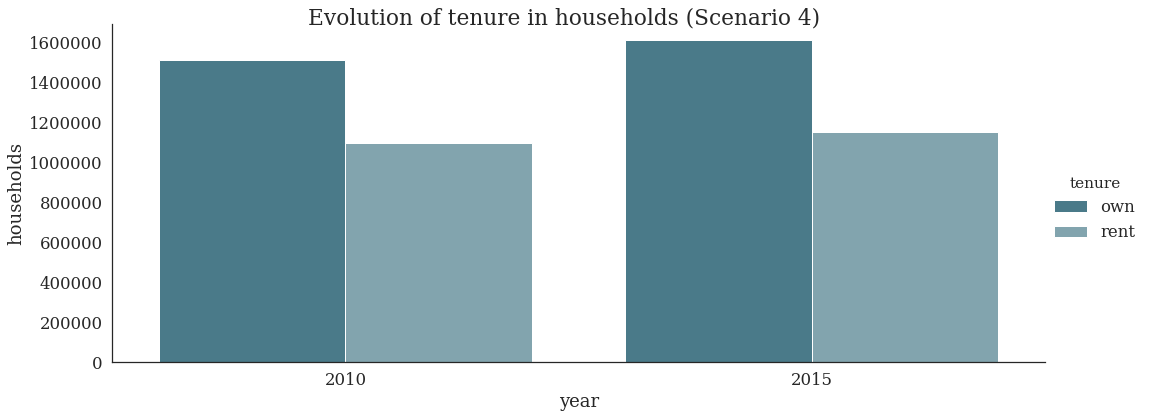

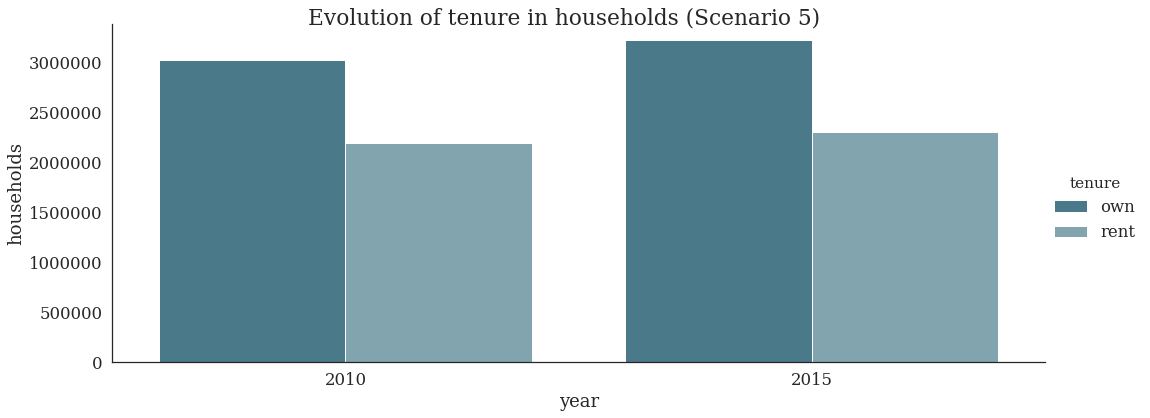

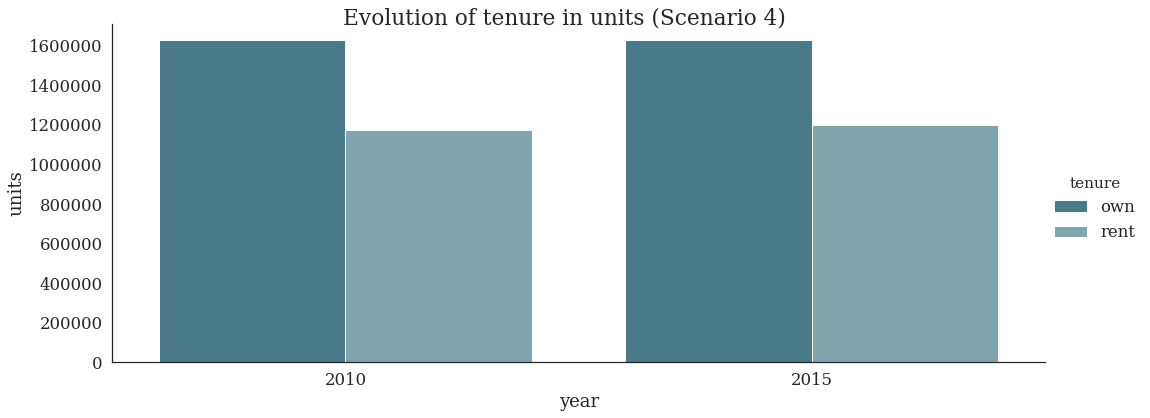

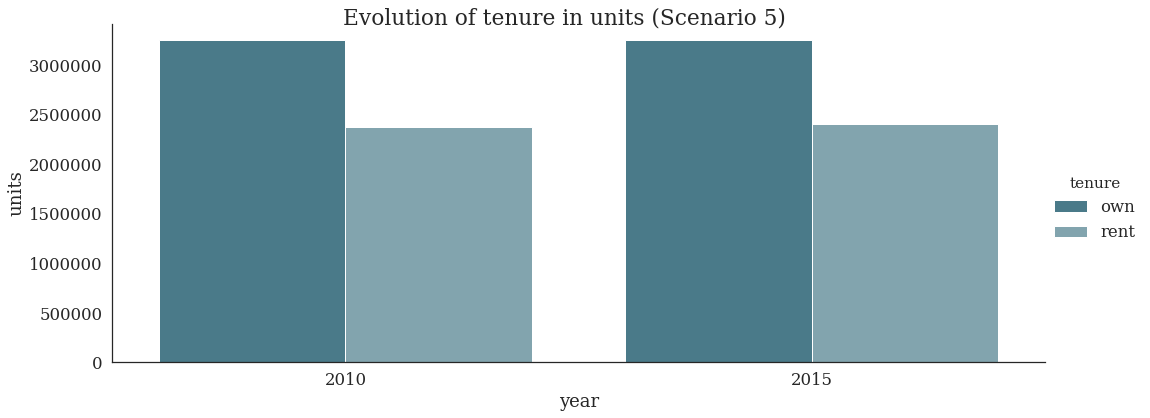

In [14]:
tenure_evolution(households_s4, 'households', 4)
tenure_evolution(households_s5, 'households', 5)
tenure_evolution(units_s4, 'units', 4)
tenure_evolution(units_s5, 'units', 5)






# VERIFICATION OF CONSISTENCY IN TENURE ASSIGNMENTS

#### We can check that owner households were assigned only to owned units, and that renter households were assigned to rented units only, as shown below:

In [18]:


units_rent_s4 = units_s4[units_s4['tenure']=='rent']
households_rent_s4 = households_s4[households_s4['tenure']=='rent']
units_own_s4 = units_s4[units_s4['tenure']=='own']
households_own_s4 = households_s4[households_s4['tenure']=='own']
units_rent_s5 = units_s5[units_s5['tenure']=='rent']
households_rent_s5 = households_s5[households_s5['tenure']=='rent']
units_own_s5 = units_s5[units_s5['tenure']=='own']
households_own_s5 = households_s5[households_s5['tenure']=='own']

units_rent_s4 = units_rent_s4.reset_index()
units_own_s4 = units_own_s4.reset_index()
units_rent_s5 = units_rent_s5.reset_index()
units_own_s5 = units_own_s5.reset_index()

print ('SCENARIO 4:')
print ('renter households assigned to owned units: ',
      len(households_rent_s4[households_rent_s4.unit_id.isin(units_own_s4.unit_id)].index))
print ('owner households assigned to rented units: ',
      len(households_own_s4[households_own_s4.unit_id.isin(units_rent_s4.unit_id)].index))

print ('SCENARIO 5:')
print ('renter households assigned to owned units: ',
      len(households_rent_s5[households_rent_s5.unit_id.isin(units_own_s5.unit_id)].index))
print ('owner households assigned to rented units: ',
      len(households_own_s5[households_own_s5.unit_id.isin(units_rent_s5.unit_id)].index))

SCENARIO 4:
('renter households assigned to owned units: ', 0)
('owner households assigned to rented units: ', 0)
SCENARIO 5:
('renter households assigned to owned units: ', 0)
('owner households assigned to rented units: ', 0)


#### Further, no households are unplaced for any of the simulation years 

In [19]:
print ('SCENARIO 4:')
print("Households with unit_id == -1",
      len(households_s4[households_s4['unit_id']==-1].index))
print("Households with null values for unit_id",
      len(households_s4[households_s4['unit_id'].isnull()].index))
print ('SCENARIO 5:')
print("Households with unit_id == -1",
      len(households_s5[households_s5['unit_id']==-1].index))
print("Households with null values for unit_id",
      len(households_s5[households_s5['unit_id'].isnull()].index))

SCENARIO 4:
('Households with unit_id == -1', 0)
('Households with null values for unit_id', 0)
SCENARIO 5:
('Households with unit_id == -1', 0)
('Households with null values for unit_id', 0)
